<a href="https://colab.research.google.com/github/asimo945/Auto_GraphenePicker/blob/main/Graphene_AOI_Classical_Image_Processing_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from skimage import measure, io
from scipy.stats import norm


In [133]:
# Function to load and process the image
def process_image(image_path, lower_hsv, upper_hsv, kernel_size, morph_iterations):
    """
    Process the image to extract the mask of the blue patches.

    Parameters:
    - image_path: str, the path to the input image.
    - lower_hsv: np.array, the lower HSV threshold for blue color detection.
    - upper_hsv: np.array, the upper HSV threshold for blue color detection.
    - kernel_size: tuple, the size of the morphological operation kernel.
    - morph_iterations: int, the number of iterations for morphological operations.

    Returns:
    - labels: the labeled mask of the image after processing.
    """
    image = cv2.imread(image_path)
    if image is None:
      raise FileNotFoundError(f"The image at {image_path} does not exist.")
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Ensure the lower and upper HSV bounds are NumPy arrays of type 'uint8'
    lower_hsv = np.array(lower_hsv, dtype=np.uint8)
    upper_hsv = np.array(upper_hsv, dtype=np.uint8)

    # Create a mask for the blue color
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)

    # Perform morphological operations to clean up the noise
    kernel = np.ones(kernel_size, np.uint8)
    mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=morph_iterations)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_DILATE, kernel, iterations=morph_iterations)

    # Label different connected regions in the mask
    labels = measure.label(mask_cleaned)
    return labels

# Function to extract properties from the labeled image
def extract_properties(labels):
    properties = measure.regionprops_table(labels, properties=('area', 'eccentricity',
                                                               'perimeter', 'solidity'))
    df_properties = pd.DataFrame(properties)
    return df_properties

# Function to save DataFrame to CSV
def save_properties(df, file_path):
    df.to_csv(file_path, index=False)

# Function to analyze the DataFrame
def analyze_properties(df):
    basic_stats = df.describe()
    skewness = df.skew()
    kurtosis = df.kurt()
    mode_area = df['area'].mode()[0]
    mad = df['area'].mad()
    return basic_stats, skewness, kurtosis, mode_area, mad

# Function to visualize the properties with histograms and fit a Gaussian distribution
def visualize_properties(df):
    properties_to_plot = ['area', 'eccentricity', 'perimeter', 'solidity']
    for property_name in properties_to_plot:
        # Calculating mean and standard deviation for the Gaussian fit
        mean, std = norm.fit(df[property_name])

        plt.figure(figsize=(10, 5))
        sns.histplot(df[property_name], bins=30, kde=False, color='skyblue', edgecolor='black')

        # Plot the Gaussian fit
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mean, std)
        plt.plot(x, p, 'k', linewidth=2)

        title = f'Histogram of ROI {property_name.capitalize()}'
        plt.title(title)
        plt.xlabel(property_name.capitalize())
        plt.ylabel('Frequency')

        # Display mean and std on graph
        text = f'Mean: {mean:.2f}\nStd: {std:.2f}'
        plt.text(xmax*0.7, plt.ylim()[1]*0.7, text, fontsize=12)

        plt.grid(True)
        plt.show()


In [134]:
# Main function to run the entire process
def main(image_path, csv_output_path, lower_hsv, upper_hsv, kernel_size, morph_iterations):
    labels = process_image(image_path, lower_hsv, upper_hsv, kernel_size, morph_iterations)
    df_properties = extract_properties(labels)
    save_properties(df_properties, csv_output_path)
    basic_stats, skewness, kurtosis, mode_area, mad = analyze_properties(df_properties)
    visualize_properties(df_properties)


<ipython-input-133-4cdff50e5323>:54: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = df['area'].mad()


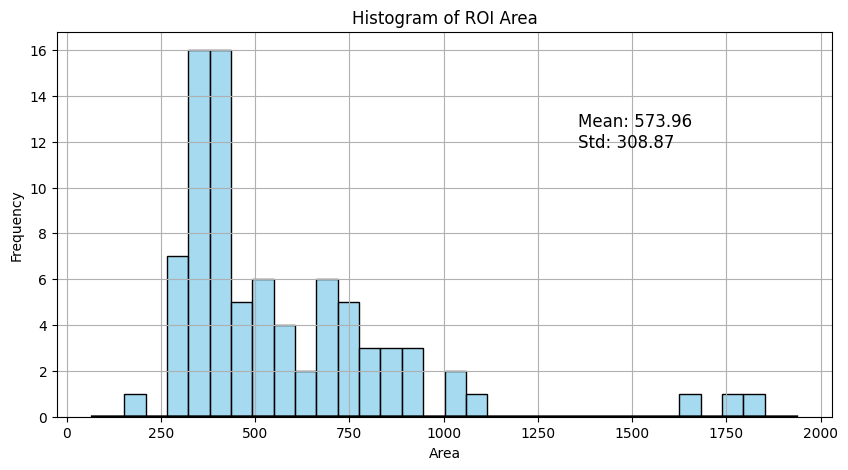

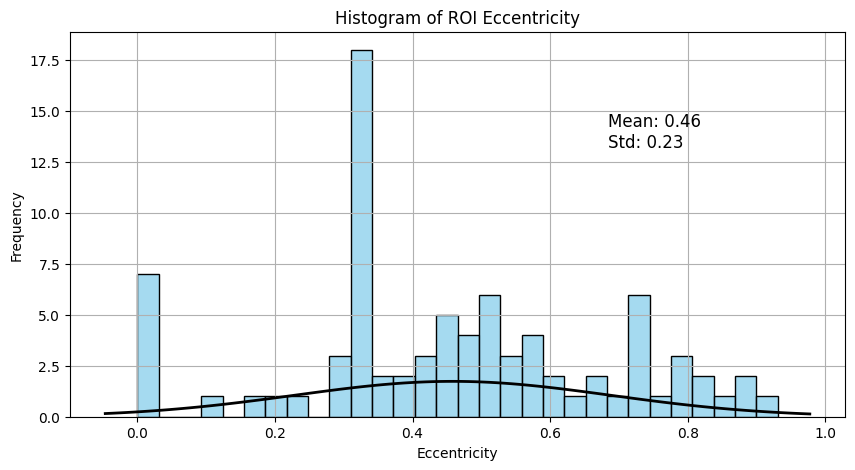

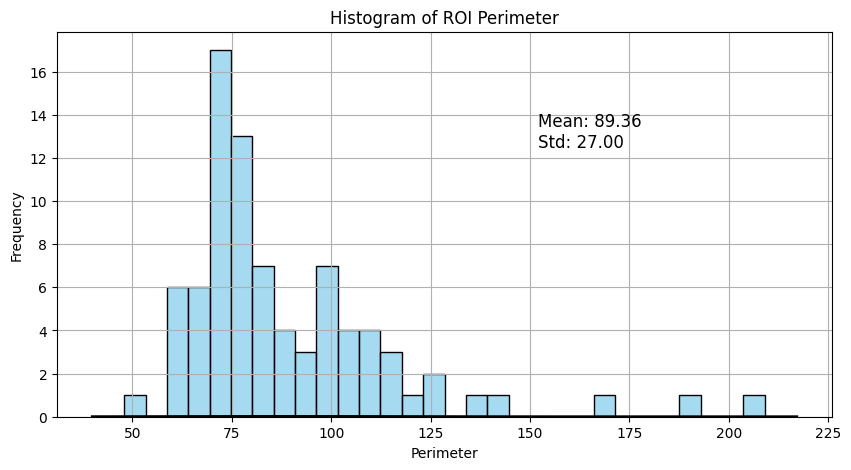

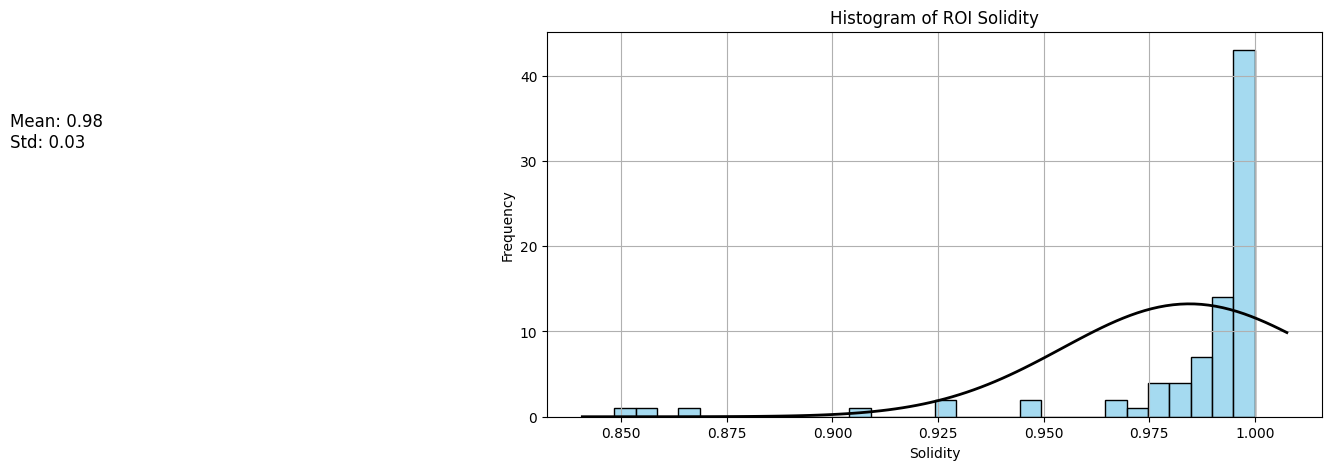

In [135]:
# Define adjustable parameters for blue color detection and morphological operations
lower_hsv = np.array([100, 50, 50])  # Lower bound for HSV selection
upper_hsv = np.array([140, 255, 255])  # Upper bound for HSV selection
kernel_size = (5, 5)  # Size of the kernel for morphological operations
morph_iterations = 2  # Number of iterations for morphological operations

# Paths for the input image and output CSV
image_path = '/content/1.jpg'
csv_output_path = 'roi_properties.csv'

# Run the main function with all required arguments
main(image_path, csv_output_path, lower_hsv, upper_hsv, kernel_size, morph_iterations)

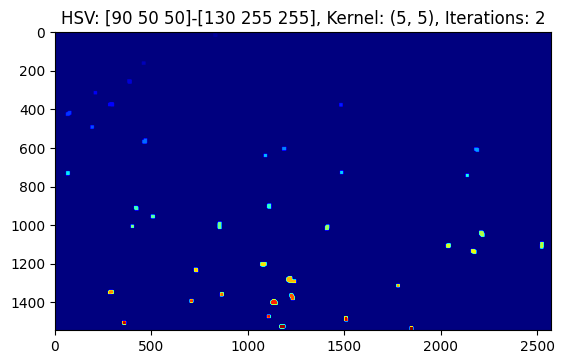

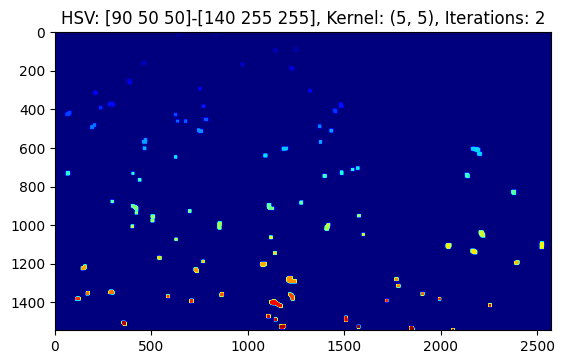

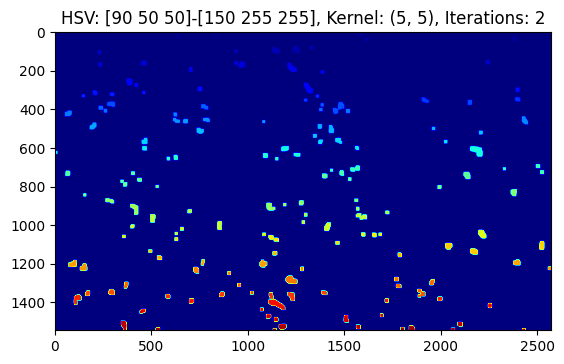

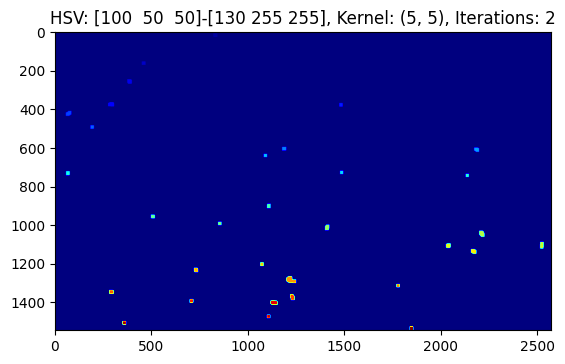

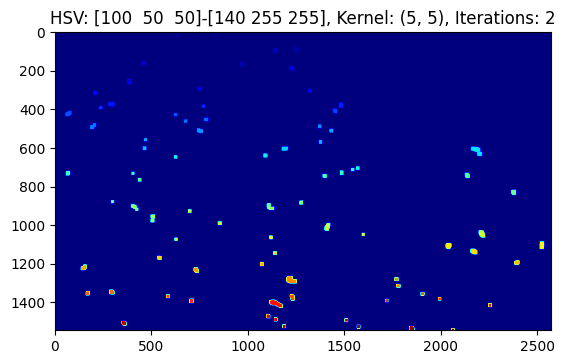

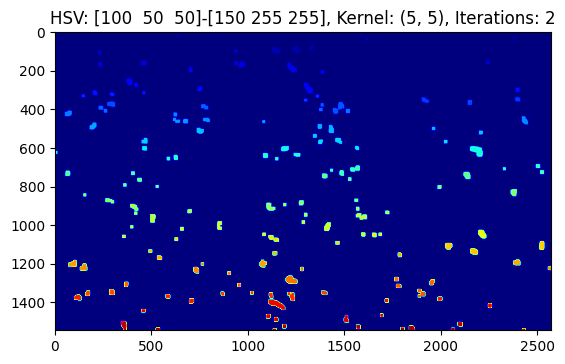

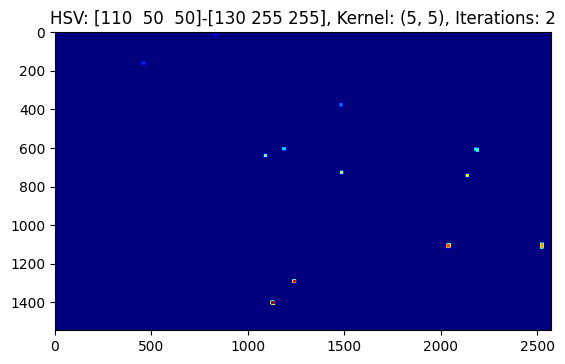

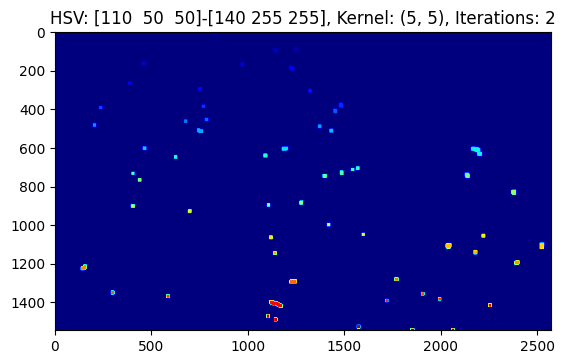

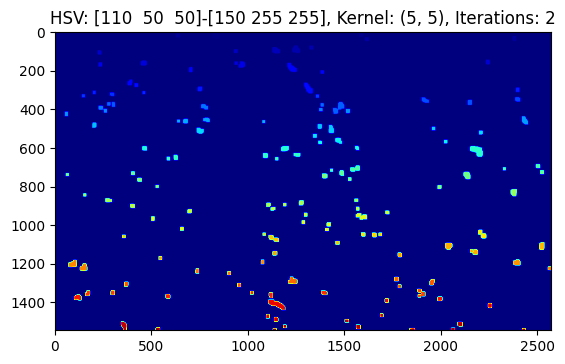

Best parameters based on the count and total area of segmented objects:
{'lower_hsv': array([90, 50, 50]), 'upper_hsv': array([150, 255, 255]), 'kernel_size': (3, 3), 'morph_iterations': 1}


In [136]:
import itertools

def visualize_segmentation(image_path, lower_hsv, upper_hsv, kernel_size, morph_iterations):
    labels = process_image(image_path, lower_hsv, upper_hsv, kernel_size, morph_iterations)
    plt.imshow(labels, cmap='jet')
    plt.title(f"HSV: {lower_hsv}-{upper_hsv}, Kernel: {kernel_size}, Iterations: {morph_iterations}")
    plt.show()

def evaluate_segmentation(labels):
    properties = measure.regionprops(labels)
    areas = [prop.area for prop in properties]
    return len(properties), sum(areas), areas

def visualize_area_histograms(image_path, param_ranges):
    fig, axes = plt.subplots(len(param_ranges['morph_iterations']), len(param_ranges['lower_hue_range']), figsize=(20, 10))

    for i, morph_iter in enumerate(param_ranges['morph_iterations']):
        for j, lower_hue in enumerate(param_ranges['lower_hue_range']):
            lower_hsv = np.array([lower_hue, 50, 50])
            upper_hsv = np.array([140, 255, 255])  # Example fixed value
            labels = process_image(image_path, lower_hsv, upper_hsv, (5, 5), int(morph_iter))
            _, _, areas = evaluate_segmentation(labels)  # Extract areas

            ax = axes[i, j] if axes.ndim > 1 else axes[max(i, j)]
            sns.histplot(areas, bins=30, kde=False, ax=ax)
            ax.set_title(f'Hue: {lower_hue}, Morph Iter: {morph_iter}')
            ax.set_xlabel('Area')
            ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Define a range of parameters to iterate through
lower_hsv_values = [np.array([h, 50, 50]) for h in range(90, 111, 10)]
upper_hsv_values = [np.array([h, 255, 255]) for h in range(130, 151, 10)]
kernel_sizes = [(k, k) for k in range(3, 6)]
morph_iterations_values = [1, 2, 3]

# Prepare for optimization and visualization
best_count = 0
best_area = 0
best_params = {}

# Iterate through all combinations of parameters
for lower_hsv, upper_hsv, kernel_size, morph_iterations in itertools.product(
    lower_hsv_values, upper_hsv_values, kernel_sizes, morph_iterations_values
):
    labels = process_image(image_path, lower_hsv, upper_hsv, kernel_size, morph_iterations)
    count, total_area,area = evaluate_segmentation(labels)

    # Update best parameters based on the evaluation metric
    if count > best_count and total_area > best_area:
        best_count = count
        best_area = total_area
        best_params = {
            'lower_hsv': lower_hsv,
            'upper_hsv': upper_hsv,
            'kernel_size': kernel_size,
            'morph_iterations': morph_iterations
        }

    # Visualize a subset of segmentations
    if (kernel_size == (5, 5)) and (morph_iterations == 2):
        visualize_segmentation(image_path, lower_hsv, upper_hsv, kernel_size, morph_iterations)

print("Best parameters based on the count and total area of segmented objects:")
print(best_params)

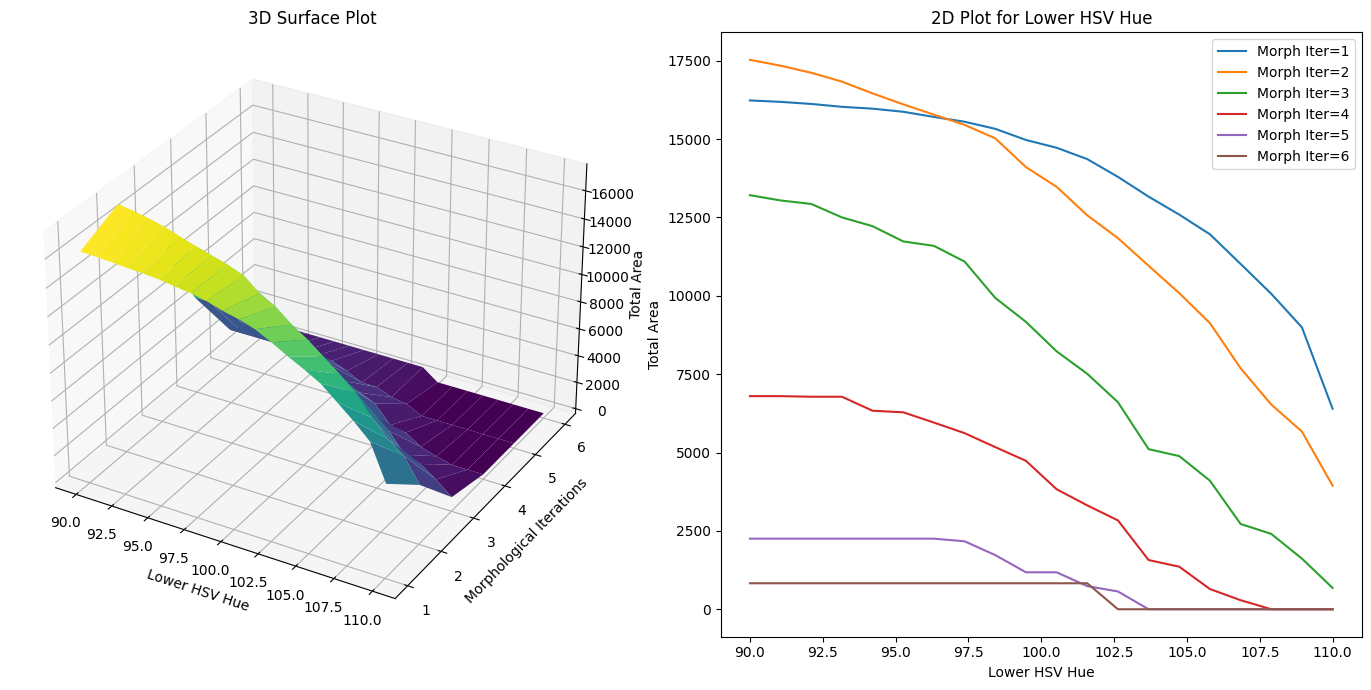

In [137]:
from mpl_toolkits.mplot3d import Axes3D

upper_hsv_fixed=np.array([120,255,255]) ## more exlporation
kernel_size_fixed=np.array((3,3))
lower_hue_range = np.linspace(90, 110, num=20)  # Example range for lower HSV hue
morph_iter_range = np.arange(1, 7)  # Example range for morphological iterations (use arange for integer steps)

# Prepare a grid for the parameters
lower_hue_values, morph_iter_values = np.meshgrid(lower_hue_range, morph_iter_range)
total_area_values = np.zeros_like(lower_hue_values, dtype=float)

# Calculate the total area for each combination of parameters
for i in range(lower_hue_values.shape[0]):
    for j in range(lower_hue_values.shape[1]):
        lower_hsv = np.array([lower_hue_values[i, j], 50, 50])
        morph_iter = morph_iter_values[i, j]

        # Process the image and evaluate segmentation
        labels = process_image(image_path, lower_hsv, upper_hsv_fixed, kernel_size_fixed, int(morph_iter))
        _, total_area, _ = evaluate_segmentation(labels)
        total_area_values[i, j] = total_area

# Plot the 3D surface
fig = plt.figure(figsize=(14, 7))

# 3D surface plot
ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(lower_hue_values, morph_iter_values, total_area_values, cmap='viridis')
ax.set_xlabel('Lower HSV Hue')
ax.set_ylabel('Morphological Iterations')
ax.set_zlabel('Total Area')
ax.set_title('3D Surface Plot')

# 2D plots for each parameter
# Plot for lower_hue_values
ax2 = fig.add_subplot(122)
for k, morph_iter in enumerate(morph_iter_range):
    ax2.plot(lower_hue_range, total_area_values[k, :], label=f'Morph Iter={morph_iter}')
ax2.set_xlabel('Lower HSV Hue')
ax2.set_ylabel('Total Area')
ax2.set_title('2D Plot for Lower HSV Hue')
ax2.legend()

plt.tight_layout()
plt.show()


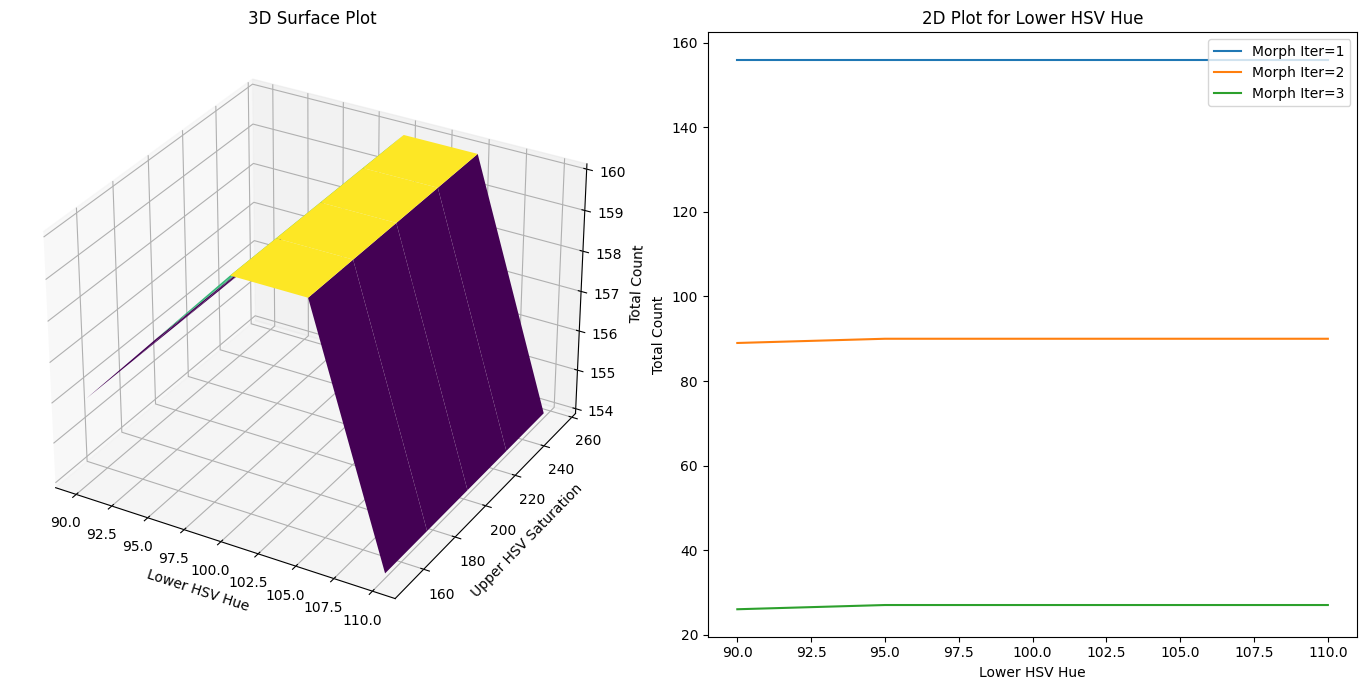

In [138]:

# Define ranges for the parameters
lower_hue_range = np.linspace(90, 110, num=5)  # Example range for lower HSV hue
upper_saturation_range = np.linspace(150, 255, num=5)  # Example range for upper HSV saturation
morph_iter_range = np.linspace(1, 3, num=3).astype(int)  # Example range for morphological iterations, cast to int

# Prepare a grid for the parameters
lower_hue_values, upper_saturation_values, morph_iter_values = np.meshgrid(
    lower_hue_range, upper_saturation_range, morph_iter_range
)

# Initialize an empty array to hold the total count of segmented objects
total_count_values = np.zeros(lower_hue_values.shape)

# Calculate the total count for each combination of parameters
for i in range(lower_hue_values.shape[0]):
    for j in range(upper_saturation_values.shape[1]):
        for k in range(morph_iter_values.shape[2]):
            lower_hsv = np.array([lower_hue_values[i, j, k], 50, 50])
            upper_hsv = np.array([140, upper_saturation_values[i, j, k], 255])
            morph_iter = morph_iter_values[i, j, k]

            # Process the image and evaluate segmentation
            labels = process_image(image_path, lower_hsv, upper_hsv, (5, 5), morph_iter)
            count, total_area, areas = evaluate_segmentation(labels)
            total_count_values[i, j, k] = count

# Plot the 3D surface
fig = plt.figure(figsize=(14, 7))

# 3D surface plot
ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(
    lower_hue_values[:, :, 0], upper_saturation_values[:, :, 0], total_count_values[:, :, 0],
    cmap='viridis', rstride=1, cstride=1, edgecolor='none'
)
ax.set_xlabel('Lower HSV Hue')
ax.set_ylabel('Upper HSV Saturation')
ax.set_zlabel('Total Count')
ax.set_title('3D Surface Plot')

# 2D plots for each parameter
# 2D Plot for lower_hue_values
ax2 = fig.add_subplot(122)
for k in range(len(morph_iter_range)):
    ax2.plot(lower_hue_range, total_count_values[:, 0, k], label=f'Morph Iter={morph_iter_range[k]}')
ax2.set_xlabel('Lower HSV Hue')
ax2.set_ylabel('Total Count')
ax2.set_title('2D Plot for Lower HSV Hue')
ax2.legend()

plt.tight_layout()
plt.show()


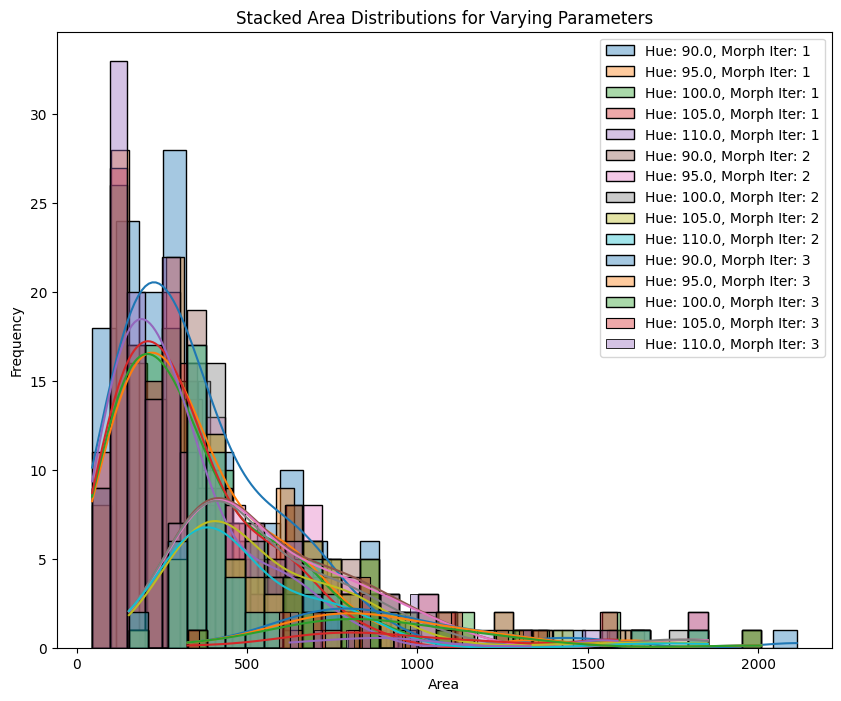

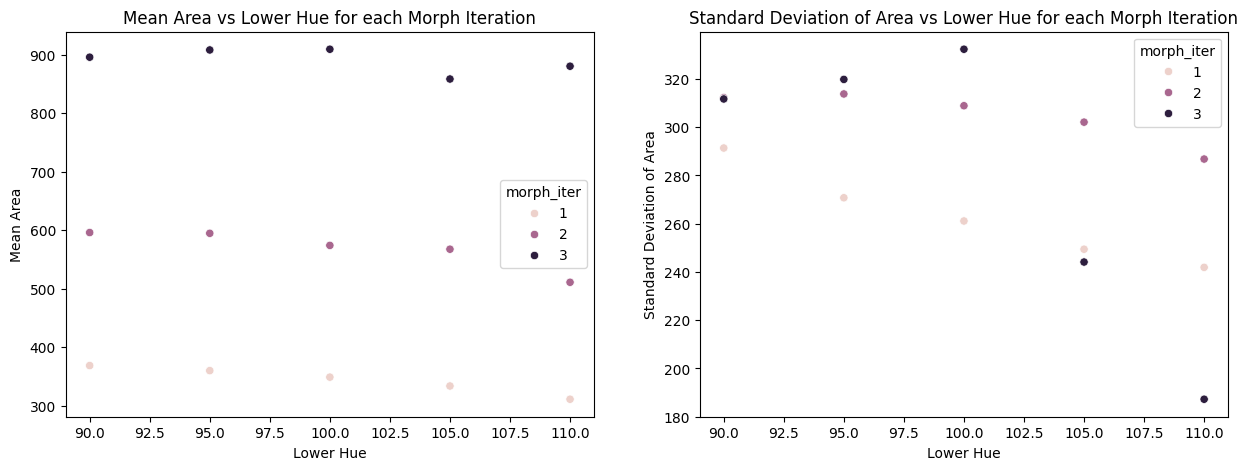

In [139]:
import seaborn as sns

def visualize_area_histograms(image_path, param_ranges):
    # Store statistics for plotting
    stats_data = {
        'lower_hue': [],
        'morph_iter': [],
        'mean_area': [],
        'std_area': []
    }

    plt.figure(figsize=(10, 8))

    # Iterate over the parameter ranges and plot the distributions
    for morph_iter in param_ranges['morph_iterations']:
        for lower_hue in param_ranges['lower_hue_range']:
            lower_hsv = np.array([lower_hue, 50, 50])
            upper_hsv = np.array([140, 255, 255])  # Fixed upper HSV value

            # Process the image and evaluate segmentation
            labels = process_image(image_path, lower_hsv, upper_hsv, (5, 5), int(morph_iter))
            count, total_area, areas = evaluate_segmentation(labels)

            # Store statistics
            stats_data['lower_hue'].append(lower_hue)
            stats_data['morph_iter'].append(morph_iter)
            stats_data['mean_area'].append(np.mean(areas))
            stats_data['std_area'].append(np.std(areas))

            # Plot the distribution with transparency
            sns.histplot(areas, bins=30, kde=True, alpha=0.4, label=f'Hue: {lower_hue}, Morph Iter: {morph_iter}')

    plt.title('Stacked Area Distributions for Varying Parameters')
    plt.xlabel('Area')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Plot how mean and standard deviation change with parameters
    stats_df = pd.DataFrame(stats_data)
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.scatterplot(x='lower_hue', y='mean_area', hue='morph_iter', data=stats_df, ax=ax[0])
    sns.scatterplot(x='lower_hue', y='std_area', hue='morph_iter', data=stats_df, ax=ax[1])

    ax[0].set_title('Mean Area vs Lower Hue for each Morph Iteration')
    ax[0].set_xlabel('Lower Hue')
    ax[0].set_ylabel('Mean Area')

    ax[1].set_title('Standard Deviation of Area vs Lower Hue for each Morph Iteration')
    ax[1].set_xlabel('Lower Hue')
    ax[1].set_ylabel('Standard Deviation of Area')
    plt.show()

# Define ranges for the parameters
param_ranges = {
    'lower_hue_range': np.linspace(90, 110, num=5),  # Example range for lower HSV hue
    'morph_iterations': np.arange(1, 4),  # Example range for morphological iterations as integers
}

# Visualize how the histogram of area changes with the variation of variables
visualize_area_histograms(image_path, param_ranges)
